In [152]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
import src.utils
importlib.reload(importlib.reload(src.utils))
from src.utils import kmeans_clustering_mlflow , transform_pca

# EXTRANJEROS

## Productos

In [153]:
rfm_productos_extranjeros = pd.read_csv('../dataset/rfm_productos_extranjeros.csv')



print(rfm_productos_extranjeros.columns)

print("cantidad de columnas: ", len(rfm_productos_extranjeros.columns))

print("cantidad de filas: ", len(rfm_productos_extranjeros))



Index(['id_producto', 'Recency', 'Frequency', 'Monetary', 'n_paises_distintos',
       'horario_promedio', '2010-12', '2011-01', '2011-02', '2011-03',
       '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09',
       '2011-10', '2011-11', '2011-12', 'Australia', 'Austria', 'Bahrain',
       'Belgium', 'Brazil', 'Canada', 'Channel Islands', 'Cyprus',
       'Czech Republic', 'Denmark', 'EIRE', 'European Community', 'Finland',
       'France', 'Germany', 'Greece', 'Iceland', 'Israel', 'Italy', 'Japan',
       'Lebanon', 'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Poland',
       'Portugal', 'RSA', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden',
       'Switzerland', 'USA', 'United Arab Emirates', 'Unspecified'],
      dtype='object')
cantidad de columnas:  55
cantidad de filas:  2781


In [154]:
rfm_productos_extranjeros.head()

,id_producto,Recency,Frequency,Monetary,n_paises_distintos,horario_promedio,2010-12,2011-01,2011-02,2011-03,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified
0,10002,253,422,358.7,6,11,108.0,193.0,1.0,0.0,...,0.0,0.0,0.0,0.0,24.0,0.0,12.0,0.0,0.0,0.0
1,10120,36,10,2.1,1,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10125,1,610,492.7,3,12,0.0,60.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
3,10133,114,130,67.5,5,12,20.0,0.0,10.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
4,10135,10,300,287.2,5,10,0.0,0.0,200.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
# Limpieza de outliers usando el método IQR para Recency, Frequency y Monetary
def remove_outliers_iqr(df, columns):
    """
    Elimina outliers usando el método IQR (Interquartile Range)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtramos los outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['Recency', 'Frequency', 'Monetary']

# Mostrar estadísticas antes de la limpieza
print("Estadísticas ANTES de la limpieza de outliers:")
print(rfm_productos_extranjeros[columns_to_clean].describe())
print(f"\nCantidad de registros antes: {len(rfm_productos_extranjeros)}")

# Aplicar limpieza de outliers
rfm_productos_extranjeros_clean = remove_outliers_iqr(rfm_productos_extranjeros, columns_to_clean)




Estadísticas ANTES de la limpieza de outliers:
           Recency     Frequency      Monetary
count  2781.000000   2781.000000   2781.000000
mean     69.030924    326.311399    537.350708
std      92.414427    760.944895   1347.455107
min       1.000000      1.000000      0.190000
25%       6.000000     24.000000     40.680000
50%      25.000000     91.000000    148.500000
75%      81.000000    323.000000    525.000000
max     374.000000  15437.000000  31551.750000

Cantidad de registros antes: 2781


In [156]:
id_producto= rfm_productos_extranjeros_clean['id_producto'].copy()

id_producto.head()

1    10120
2    10125
3    10133
4    10135
5    11001
Name: id_producto, dtype: object

In [157]:
rfm_productos_extranjeros_clean.drop(columns=['id_producto','n_paises_distintos'], inplace=True)

In [158]:
rfm_productos_extranjeros_clean

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified
1,36,10,2.10,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,610,492.70,12,0.0,60.0,0.0,40.0,20.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
3,114,130,67.50,12,20.0,0.0,10.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
4,10,300,287.20,10,0.0,0.0,200.0,60.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,15,144,243.36,13,16.0,16.0,0.0,0.0,0.0,0.0,...,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,78,4,6.60,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2777,78,4,6.60,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2778,78,6,15.30,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2779,78,6,12.60,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
# Calcular las componentes principales (2 componentes)
componentes = transform_pca(rfm_productos_extranjeros_clean, 2)

# Calcular la varianza explicada por cada componente principal


dataframe_pca = pd.DataFrame(componentes, columns=['PC1', 'PC2'],index=rfm_productos_extranjeros_clean.index)


dataframe_pca.head()



,PC1,PC2
1,-0.243662,-0.172136
2,0.780048,0.122333
3,-0.246866,0.313773
4,0.301849,-0.004301
5,0.087542,-0.134637


### K-means con 3 cluster

🏃 View run K=1 at: http://localhost:5000/#/experiments/990448571672273184/runs/4701d1bd4fbc4902bab13c894acddd27
🧪 View experiment at: http://localhost:5000/#/experiments/990448571672273184
🏃 View run K=2 at: http://localhost:5000/#/experiments/990448571672273184/runs/1e76cd1546ce4db59d87d2eed420792c
🧪 View experiment at: http://localhost:5000/#/experiments/990448571672273184
🏃 View run K=3 at: http://localhost:5000/#/experiments/990448571672273184/runs/26f01f4bf448449981f61f2b5e5fe20a
🧪 View experiment at: http://localhost:5000/#/experiments/990448571672273184
🏃 View run K=4 at: http://localhost:5000/#/experiments/990448571672273184/runs/def2b7be7dcd45dfaeb451113009b37a
🧪 View experiment at: http://localhost:5000/#/experiments/990448571672273184
🏃 View run K=5 at: http://localhost:5000/#/experiments/990448571672273184/runs/735942210f8744f78422628782fc66ae
🧪 View experiment at: http://localhost:5000/#/experiments/990448571672273184
🏃 View run K=6 at: http://localhost:5000/#/experiments/

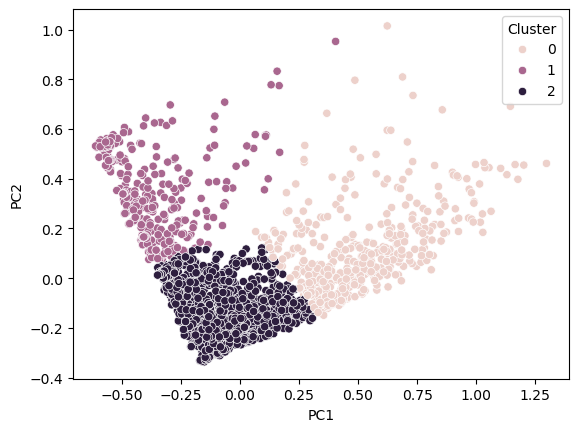

In [163]:

data_pca_cluster=kmeans_clustering_mlflow(dataframe_pca, ['PC1', 'PC2'],10,3,'K-MEANS-PRODUCTOS_EXTRANJEROS')

sns.scatterplot(data=data_pca_cluster,x='PC1',y='PC2',hue='Cluster')
plt.show()

In [164]:
data_pca_cluster

,PC1,PC2,Cluster
1,-0.243662,-0.172136,2
2,0.780048,0.122333,0
3,-0.246866,0.313773,1
4,0.301849,-0.004301,0
5,0.087542,-0.134637,2
...,...,...,...
2776,-0.346328,0.012963,2
2777,-0.346328,0.012963,2
2778,-0.338953,0.015822,2
2779,-0.340530,0.015295,2


In [165]:
id_producto.index = data_pca_cluster.index

In [166]:
data_pca_cluster['id_producto'] = id_producto

In [167]:
data_pca_cluster = data_pca_cluster[['id_producto', 'PC1', 'PC2', 'Cluster']]

In [168]:
data_pca_cluster

,id_producto,PC1,PC2,Cluster
1,10120,-0.243662,-0.172136,2
2,10125,0.780048,0.122333,0
3,10133,-0.246866,0.313773,1
4,10135,0.301849,-0.004301,0
5,11001,0.087542,-0.134637,2
...,...,...,...,...
2776,90205A,-0.346328,0.012963,2
2777,90205C,-0.346328,0.012963,2
2778,90208,-0.338953,0.015822,2
2779,90209A,-0.340530,0.015295,2


In [169]:
rfm_productos_extranjeros_clean['Cluster']=data_pca_cluster['Cluster']
rfm_productos_extranjeros_clean['id_producto']=id_producto




In [170]:
rfm_productos_extranjeros_clean.head()

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified,Cluster,id_producto
1,36,10,2.10,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,10120
2,1,610,492.70,12,0.0,60.0,0.0,40.0,20.0,100.0,...,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0,10125
3,114,130,67.50,12,20.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,1,10133
4,10,300,287.20,10,0.0,0.0,200.0,60.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10135
5,15,144,243.36,13,16.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,2,11001


In [171]:
rfm_productos_extranjeros_clean.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon', 'Lithuania', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'RSA', 'Saudi Arabia',
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'USA',
       'United Arab Emirates', 'Unspecified', 'Cluster', 'id_producto'],
      dtype='object')

estadistica descriptiva

In [172]:
cluster_summary = rfm_productos_extranjeros_clean.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary)

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified
Cluster,,,,,,,,,,,,,,,,,,,,,
0,20.516204,402.888889,523.704051,12.085648,20.594907,28.914352,20.747685,26.807870,13.537037,28.967593,...,7.819444,0.081019,0.013889,4.712963,14.400463,11.986111,17.513889,1.754630,0.488426,1.074074
1,135.461774,59.629969,88.807125,11.932722,4.636086,7.064220,3.180428,6.272171,4.902141,5.584098,...,0.850153,0.000000,0.018349,1.125382,2.590214,0.140673,2.094801,0.033639,0.256881,0.602446
2,30.115541,77.524003,136.955509,12.310008,4.015460,4.194467,2.831570,3.676159,2.161920,4.363710,...,2.348251,0.047193,0.004882,0.801465,3.900732,0.512612,3.912124,0.180635,0.152970,0.292107


In [173]:
cluster_summary.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon', 'Lithuania', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'RSA', 'Saudi Arabia',
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'USA',
       'United Arab Emirates', 'Unspecified'],
      dtype='object')

#### cantidad mensuales promedios en los periodos

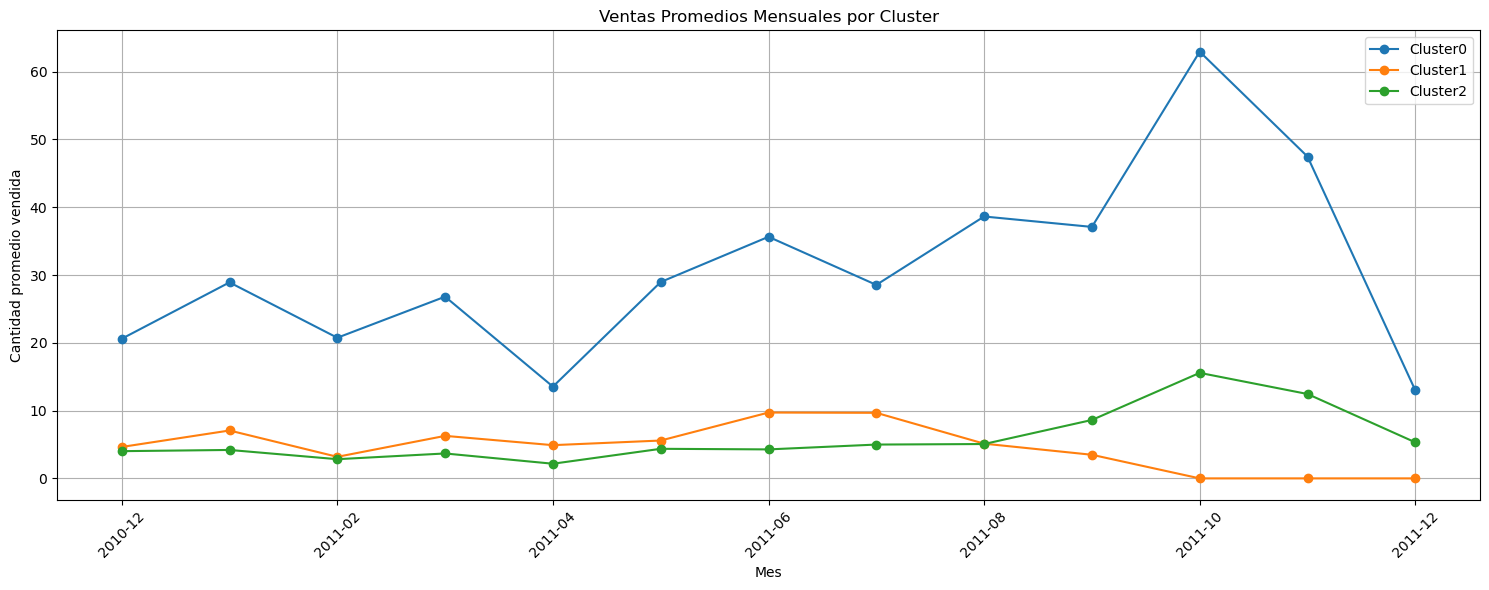

In [174]:
cluster0_mes= cluster_summary.iloc[0].T
cluster1_mes= cluster_summary.iloc[1].T
cluster2_mes= cluster_summary.iloc[2].T

columnas_fechas = [col for col in rfm_productos_extranjeros_clean.columns if col.startswith('201')]

cluster0_mes=cluster0_mes[columnas_fechas]
cluster1_mes=cluster1_mes[columnas_fechas]
cluster2_mes=cluster2_mes[columnas_fechas]

ventas_promedios_mensuales=pd.concat([cluster0_mes,cluster1_mes,cluster2_mes],axis=1)
ventas_promedios_mensuales.columns=['Cluster0','Cluster1','Cluster2']

ventas_promedios_mensuales.plot(
    figsize=(15, 6),
    title='Ventas Promedios Mensuales por Cluster',
    marker='o' ,
    markersize=6 )

plt.xlabel("Mes")
plt.ylabel("Cantidad promedio vendida")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



- CLUSTER 0: PRODUCTOS DE ALTAS VENTAS Y ESTACIONALIDAD 

    - ventas significativamente mas altas que los otros clusters en todos los meses 

    - se observan picos de ventas:

        - junio y agosto de 2021

        - maximo absoluto en octubre de 2011

    - caida abrupta en en diciembre 2011

        -son estacionales con pico en pre-navidad o algun evento festivo

este cluster probalmente agrupa producto estrellas, con alat rotacion en momentos especificos.

- Cluster 1: Productos estables y de baja rotación

    - Ventas bajas y bastante constantes en el tiempo.

    - Pequeños picos en enero y junio 2011, pero sin grandes saltos.

    - En octubre-diciembre las ventas caen casi a cero.

 Este cluster puede contener productos complementarios, de nicho o con baja demanda sostenida. Recomendación: manejar con stock bajo, tal vez aplicar promociones o bundling.

- Cluster 2: Productos en crecimiento o con ciclo de vida temprano

    - Ventas similares a Cluster 1 al inicio, pero con una tendencia creciente a partir de julio/agosto.

    - Pico en octubre, seguido de descenso en diciembre.

    - El comportamiento es menos volátil que el de Cluster 0, pero más dinámico que Cluster 1.


 Podría tratarse de nuevos productos que fueron ganando tracción en el mercado. Interesantes para campañas de expansión o prueba de nuevos canales.

#### cantidad vendida promedio por paises

In [175]:
paises=['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon', 'Lithuania', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'RSA', 'Saudi Arabia',
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'USA',
       'United Arab Emirates', 'Unspecified']


cantidad_de_paises=len(paises)
print(cantidad_de_paises)

cluester0_paises=cluster_summary.iloc[0].T
cluester1_paises=cluster_summary.iloc[1].T
cluester2_paises=cluster_summary.iloc[2].T

cluester0_paises=cluester0_paises[paises]
cluester1_paises=cluester1_paises[paises]
cluester2_paises=cluester2_paises[paises]

venta_promedio_paises=pd.concat([cluester0_paises,cluester1_paises,cluester2_paises],axis=1)
venta_promedio_paises.columns=['Cluster 0','Cluster 1','Cluster 2']


venta_promedio_paises.head(5)


36


,Cluster 0,Cluster 1,Cluster 2
Australia,35.548611,3.672783,3.244101
Austria,2.483796,0.103976,0.580146
Bahrain,0.032407,0.018349,0.026037
Belgium,7.685185,1.318043,2.428804
Brazil,0.074074,0.000000,0.035801


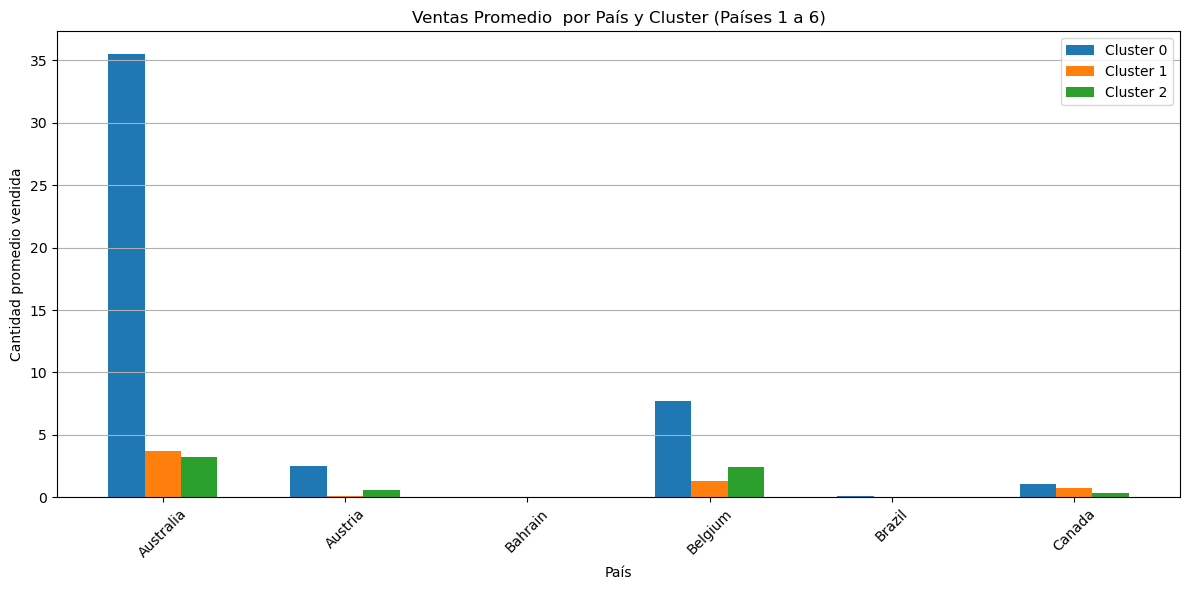

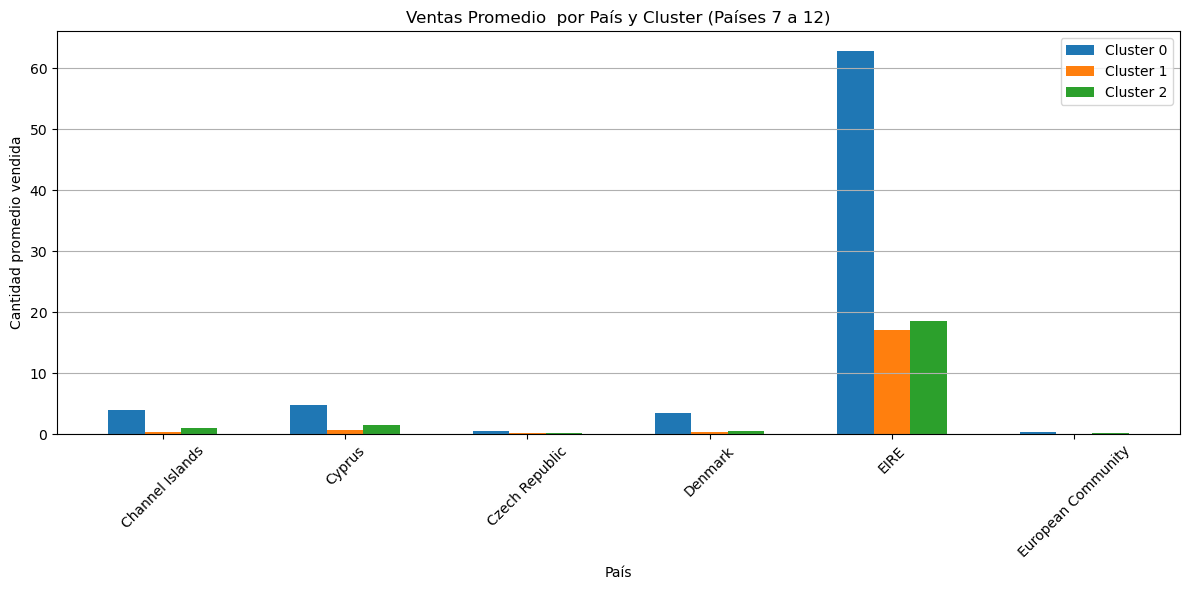

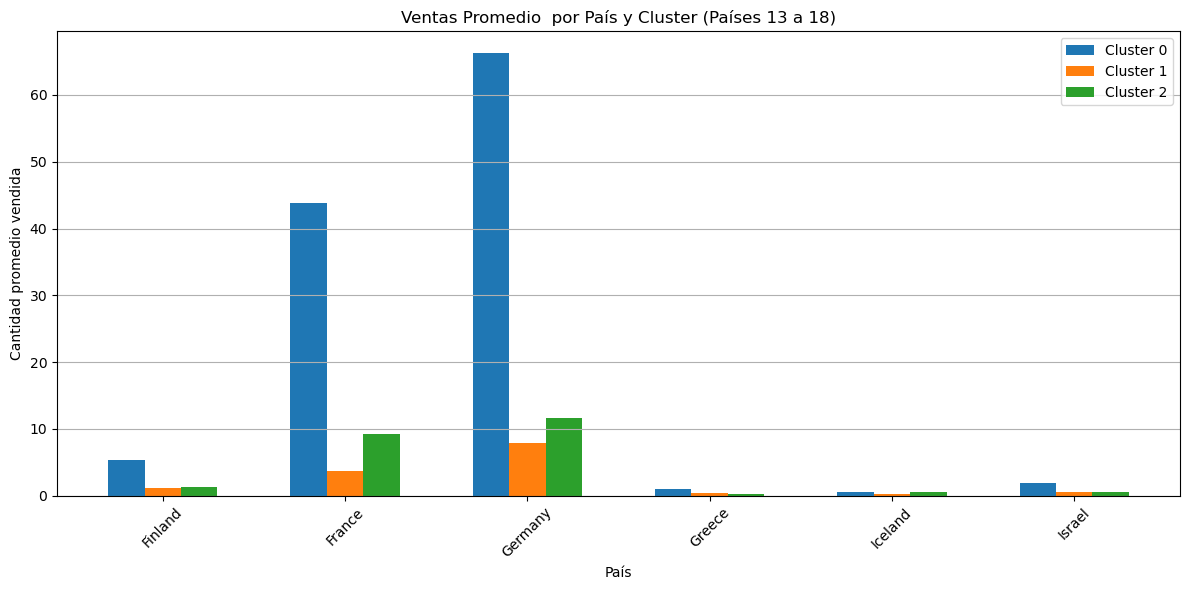

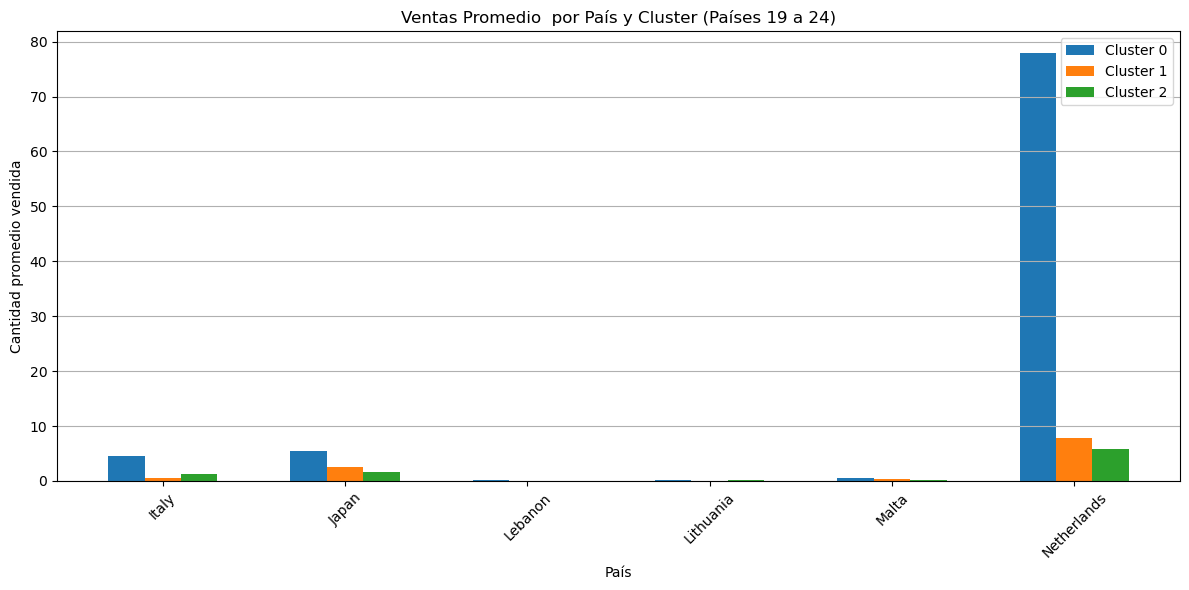

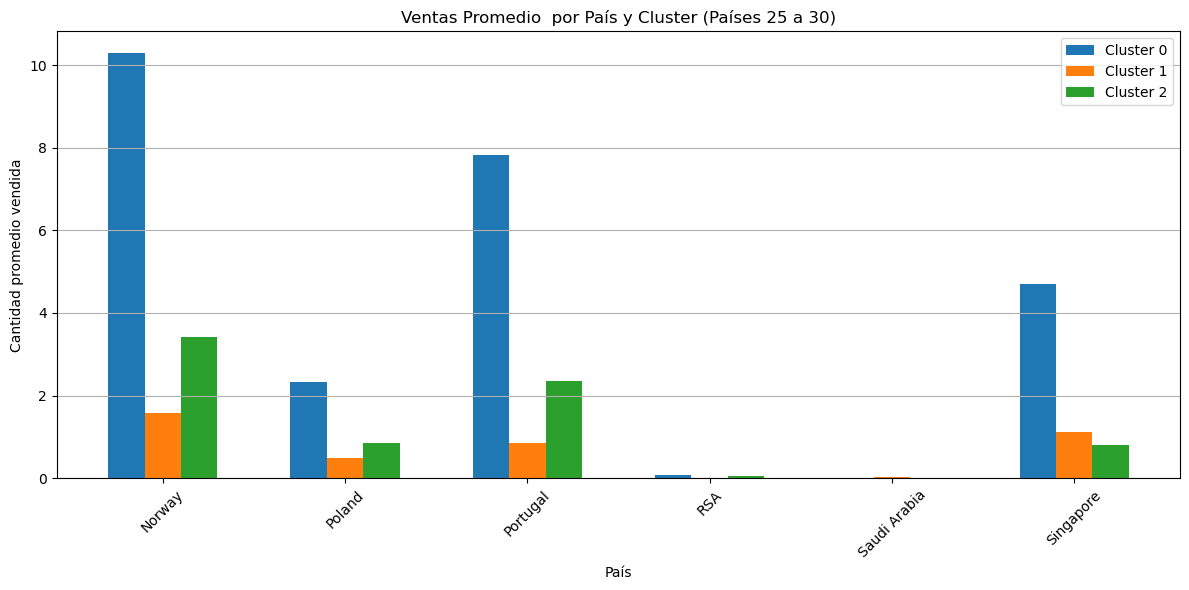

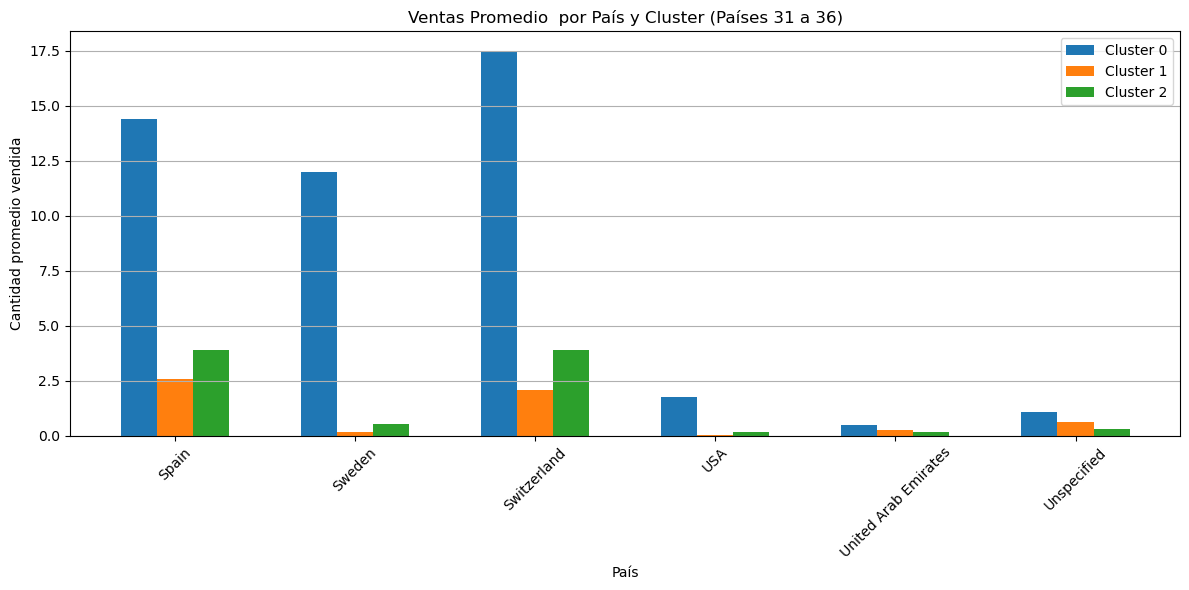

In [176]:

# Subconjunto de países y valores (6 países por lote)
lote = 6
total_paises = venta_promedio_paises.shape[0]
num_graficos = int(np.ceil(total_paises / lote))

for i in range(num_graficos):
    start = i * lote
    end = min(start + lote, total_paises)
    datos_lote = venta_promedio_paises.iloc[start:end]  # DataFrame con filas y 3 columnas

    # Parámetros para barras agrupadas
    n_paises = datos_lote.shape[0]
    n_clusters = datos_lote.shape[1]
    x = np.arange(n_paises)  # posiciones para países en eje X
    width = 0.2  # ancho de cada barra

    plt.figure(figsize=(12,6))
    for j in range(n_clusters):
        plt.bar(x + j*width, datos_lote.iloc[:, j], width=width, label=datos_lote.columns[j])

    plt.title(f'Ventas Promedio  por País y Cluster (Países {start+1} a {end})')
    plt.xlabel('País')
    plt.ylabel('Cantidad promedio vendida')
    plt.xticks(x + width, datos_lote.index, rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


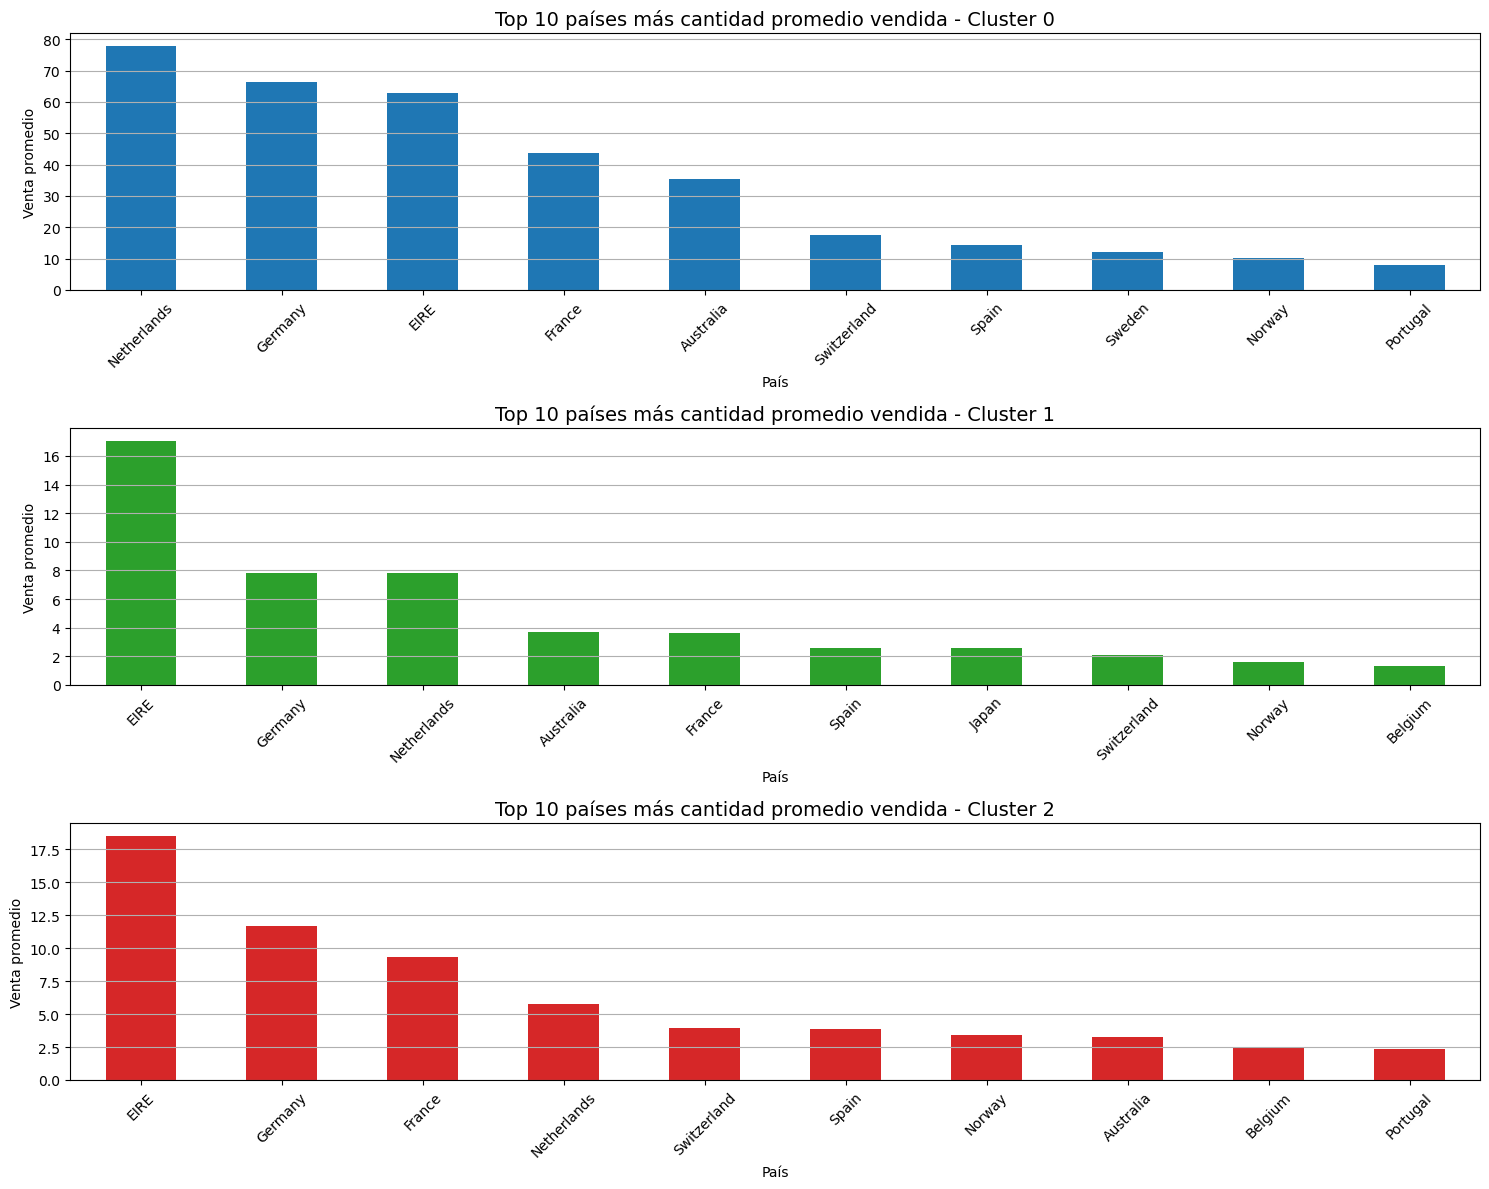

In [177]:


top_mas_vendido_cluster0_pais = venta_promedio_paises.sort_values(by='Cluster 0', ascending=False)['Cluster 0'].head(10)
top_mas_vendido_cluster1_pais = venta_promedio_paises.sort_values(by='Cluster 1', ascending=False)['Cluster 1'].head(10)
top_mas_vendido_cluster2_pais = venta_promedio_paises.sort_values(by='Cluster 2', ascending=False)['Cluster 2'].head(10)

top_10_mas_vendido = [
    top_mas_vendido_cluster0_pais, 
    top_mas_vendido_cluster1_pais, 
    top_mas_vendido_cluster2_pais
]
colors = ['#1f77b4', '#2ca02c', '#d62728']  
fig, axs = plt.subplots(3, 1, figsize=(15, 12))  

for i, cluster_data in enumerate(top_10_mas_vendido):
    cluster_data.plot(kind='bar', ax=axs[i], color=colors[i])
    axs[i].set_title(f'Top 10 países más cantidad promedio vendida - Cluster {i}', fontsize=14)
    axs[i].set_xlabel('País')
    axs[i].set_ylabel('Venta promedio')
    axs[i].set_xticks(range(len(cluster_data)))
    axs[i].set_xticklabels(cluster_data.index, rotation=45)
    axs[i].grid(axis='y')

plt.tight_layout()
plt.show()







#### RFM

In [178]:
rfm_columnas=['Recency', 'Frequency', 'Monetary']
cluster0_rfm=cluster_summary.iloc[0].T
cluster1_rfm=cluster_summary.iloc[1].T
cluster2_rfm=cluster_summary.iloc[2].T

cluster0_rfm=cluster0_rfm[rfm_columnas]
cluster1_rfm=cluster1_rfm[rfm_columnas]
cluster2_rfm=cluster2_rfm[rfm_columnas]

rfm_promedio_cluster=pd.concat([cluster0_rfm,cluster1_rfm,cluster2_rfm],axis=1)
rfm_promedio_cluster.columns=['Cluster 0','Cluster 1','Cluster 2']





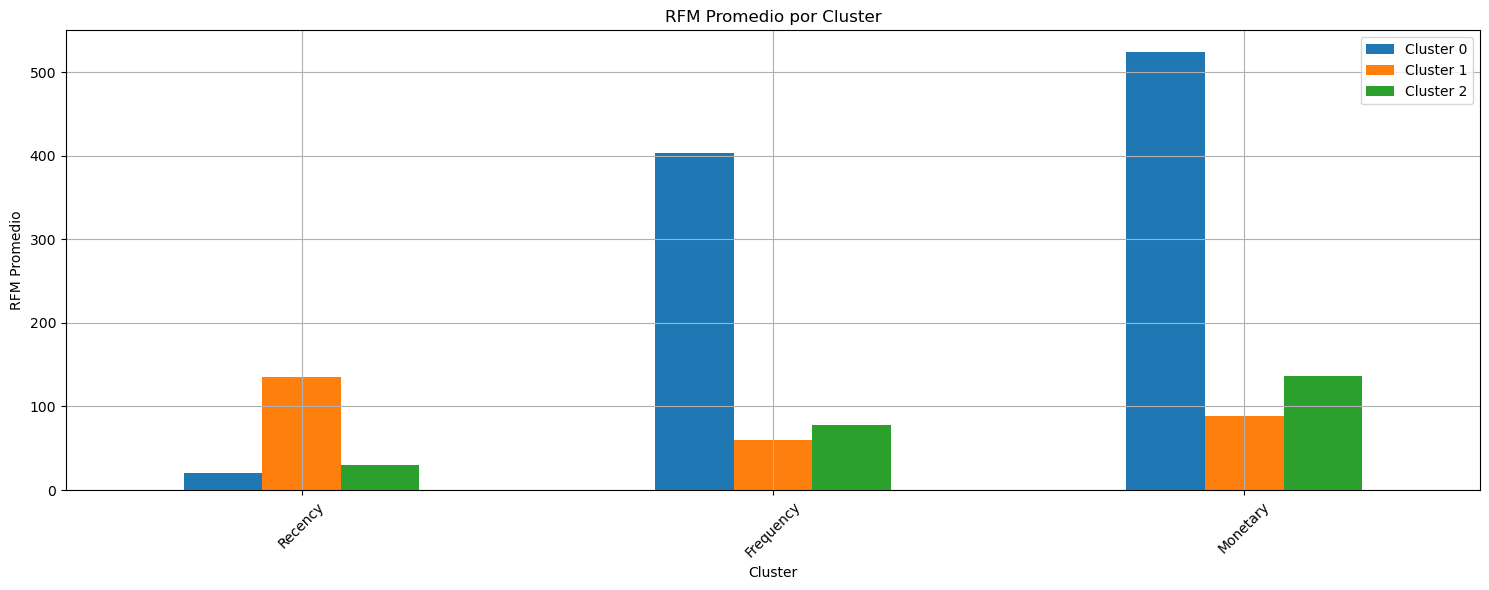

In [179]:
rfm_promedio_cluster.plot(kind='bar', figsize=(15, 6))
plt.title('RFM Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('RFM Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

- `Cluster 0`:

    - Tiene un valor muy bajo en Recency (aproximadamente 20), lo que indica que esos productos se compraron hace poco tiempo .

    - Tiene valores muy altos en Frequency (cerca de 400) y Monetary (más de 500), por lo que lo compran mucho dentro de periodos cortos de tiempo y gastan mucho.

    - Esto podría indicar productos estrellas y fieles con una alta rotacion.

- `Cluster 1`:

    - Tiene el valor más alto en Recency (~135), lo que indica que sus productos compraron hace mucho (alta recencia).

    - Tiene valores bajos en Frequency (~60) y Monetary (~90), o sea compran menos seguido y gastan menos.

    - Esto puede representar productos poco frecuentes,quizas bienes de lujos que lo compran algunas personas

- `Cluster 2`:

    - Tiene valores intermedios en Recency (~30), indicando que compraron no hace mucho, pero menos reciente que Cluster 1.

    - Tiene valores medios en Frequency (~80) y Monetary (~135), por lo que compran con moderada frecuencia y gasto.

    - Este cluster parece representar productos regulares, con compras no muy recientes, frecuencia y gasto moderados.

#### conclusion 

## Clientes

In [10]:
clientes_extranjeros = pd.read_csv('../dataset/rfm_clientes_extranjeros.csv')

clientes_extranjeros.drop(columns=['id_cliente'], inplace=True)

print(clientes_extranjeros.columns)



Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12'],
      dtype='object')


In [11]:
# Limpieza de outliers para Recency, Frequency y Monetary
print("Forma original del dataset:", clientes_extranjeros.shape)

# Función para detectar outliers usando IQR
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Contar outliers antes de remover
        outliers_count = len(df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)])
        print(f"Outliers en {col}: {outliers_count} ({outliers_count/len(df_clean)*100:.2f}%)")
        
        # Remover outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['Recency', 'Frequency', 'Monetary']

# Aplicar limpieza de outliers
clientes_extranjeros_clean = remove_outliers_iqr(clientes_extranjeros, columns_to_clean)

print("Forma nueva del dataset:", clientes_extranjeros_clean.shape)


Forma original del dataset: (418, 17)
Outliers en Recency: 24 (5.74%)
Outliers en Frequency: 40 (10.15%)
Outliers en Monetary: 34 (9.60%)
Forma nueva del dataset: (320, 17)


In [16]:
kmeans_clustering_mlflow(clientes_extranjeros_clean, ['Recency', 'Frequency', 'Monetary','horario_promedio'],10,3,'K-MEANS-CLIENTES-EXTRANJEROS')

🏃 View run K=1 at: http://localhost:5000/#/experiments/302917147741213049/runs/a06394d3132545e9be8e0d29ab2740b9
🧪 View experiment at: http://localhost:5000/#/experiments/302917147741213049
🏃 View run K=2 at: http://localhost:5000/#/experiments/302917147741213049/runs/679ca8336ff24457980db06c098423c5
🧪 View experiment at: http://localhost:5000/#/experiments/302917147741213049
🏃 View run K=3 at: http://localhost:5000/#/experiments/302917147741213049/runs/9b9294c13fd6420d9f95ebb872d39f55
🧪 View experiment at: http://localhost:5000/#/experiments/302917147741213049
🏃 View run K=4 at: http://localhost:5000/#/experiments/302917147741213049/runs/7ba2567e4cc24df199d291a32b1b9ed6
🧪 View experiment at: http://localhost:5000/#/experiments/302917147741213049
🏃 View run K=5 at: http://localhost:5000/#/experiments/302917147741213049/runs/68576eaa8a0a4403967ca7c0b14bd74a
🧪 View experiment at: http://localhost:5000/#/experiments/302917147741213049
🏃 View run K=6 at: http://localhost:5000/#/experiments/

# LOCAL

## PRODUCTOS

In [15]:
productos_local = pd.read_csv('../dataset/rfm_productos_local.csv')

print(productos_local.columns)

print("cantidad de columnas: ", len(productos_local.columns))

print("cantidad de filas: ", len(productos_local))



Index(['id_producto', 'recency', 'frequency', 'monetary', 'horario_promedio',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12'],
      dtype='object')
cantidad de columnas:  18
cantidad de filas:  3638


In [17]:
productos_local.drop(columns=['id_producto'], inplace=True)

In [20]:
# Limpieza de outliers usando el método IQR para Recency, Frequency y Monetary
def remove_outliers_iqr(df, columns):
    """
    Elimina outliers usando el método IQR (Interquartile Range)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtramos los outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['recency', 'frequency', 'monetary']

producto_local_clean = remove_outliers_iqr(productos_local, columns_to_clean)



In [22]:
kmeans_clustering_mlflow(producto_local_clean, ['recency', 'frequency', 'monetary'],10,3,'KMEANS_PRODUCTO_LOCAL')

🏃 View run K=1 at: http://localhost:5000/#/experiments/768932697419387509/runs/2228399d62a84890bda503fcf8fc7efb
🧪 View experiment at: http://localhost:5000/#/experiments/768932697419387509
🏃 View run K=2 at: http://localhost:5000/#/experiments/768932697419387509/runs/9ece35ebb1dd49f6bd17dfc2c8d7c76d
🧪 View experiment at: http://localhost:5000/#/experiments/768932697419387509
🏃 View run K=3 at: http://localhost:5000/#/experiments/768932697419387509/runs/831a7db2043b468b987ec8e1d08d7099
🧪 View experiment at: http://localhost:5000/#/experiments/768932697419387509
🏃 View run K=4 at: http://localhost:5000/#/experiments/768932697419387509/runs/a649aa9a0d334d45bb39abb63390a281
🧪 View experiment at: http://localhost:5000/#/experiments/768932697419387509
🏃 View run K=5 at: http://localhost:5000/#/experiments/768932697419387509/runs/5c6109ff4d4349a7a98a37b5067ca701
🧪 View experiment at: http://localhost:5000/#/experiments/768932697419387509
🏃 View run K=6 at: http://localhost:5000/#/experiments/

## CLIENTES

In [24]:
cliente_local = pd.read_csv('../dataset/rfm_clientes_locales.csv')

print(cliente_local.columns)

print("cantidad de columnas: ", len(cliente_local.columns))

print("cantidad de filas: ", len(cliente_local))



Index(['id_cliente', 'Recency', 'Frequency', 'Monetary', 'horario_promedio',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12'],
      dtype='object')
cantidad de columnas:  18
cantidad de filas:  3915


In [25]:
cliente_local.drop(columns=['id_cliente'], inplace=True)

In [28]:
# Limpieza de outliers usando el método IQR para Recency, Frequency y Monetary
def remove_outliers_iqr(df, columns):
    """
    Elimina outliers usando el método IQR (Interquartile Range)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtramos los outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['Recency', 'Frequency', 'Monetary']

cliente_local_clean = remove_outliers_iqr(cliente_local, columns_to_clean)


In [29]:
kmeans_clustering_mlflow(cliente_local_clean, ['Recency', 'Frequency', 'Monetary'],10,3,'K-Means_Clientes_Locales')

🏃 View run K=1 at: http://localhost:5000/#/experiments/940887523690596510/runs/623b58e593894b8290b4f3f30630c082
🧪 View experiment at: http://localhost:5000/#/experiments/940887523690596510
🏃 View run K=2 at: http://localhost:5000/#/experiments/940887523690596510/runs/be251c545f124e28ae812f13f068a951
🧪 View experiment at: http://localhost:5000/#/experiments/940887523690596510
🏃 View run K=3 at: http://localhost:5000/#/experiments/940887523690596510/runs/88c77d83f7314e2396366d9ebb156e71
🧪 View experiment at: http://localhost:5000/#/experiments/940887523690596510
🏃 View run K=4 at: http://localhost:5000/#/experiments/940887523690596510/runs/d26dcb6c569a4d76a6ec27047aee20b2
🧪 View experiment at: http://localhost:5000/#/experiments/940887523690596510
🏃 View run K=5 at: http://localhost:5000/#/experiments/940887523690596510/runs/2e480bccb76d4b8b864ea83df410dfb9
🧪 View experiment at: http://localhost:5000/#/experiments/940887523690596510
🏃 View run K=6 at: http://localhost:5000/#/experiments/